# Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

# Exploratory Data Analysis (EDA)

In [3]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# unique values and missing values
stats=[]
for col in train.columns:
    stats.append((col, train[col].nunique(),
        train[col].isnull().sum() * 100 / train.shape[0],
        train[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
        train[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 
        'Percentage of missing values',
        'Percentage of values in the biggest category','type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
72,PoolQC,3,99.520548,99.520548,object
74,MiscFeature,4,96.301370,96.301370,object
6,Alley,2,93.767123,93.767123,object
73,Fence,4,80.753425,80.753425,object
57,FireplaceQu,5,47.260274,47.260274,object
3,LotFrontage,110,17.739726,17.739726,float64
59,GarageYrBlt,97,5.547945,5.547945,float64
64,GarageCond,5,5.547945,90.821918,object
58,GarageType,6,5.547945,59.589041,object
60,GarageFinish,3,5.547945,41.438356,object


<AxesSubplot:>

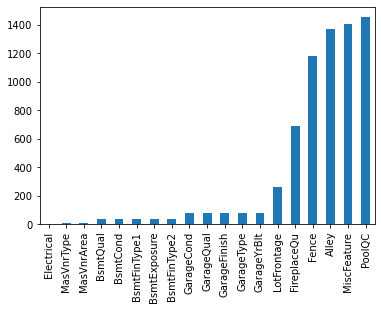

In [5]:
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
plt.figure(figsize=(9, 8))
sns.distplot(train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

/Users/johnnyli/miniforge3/envs/summer_clothes/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

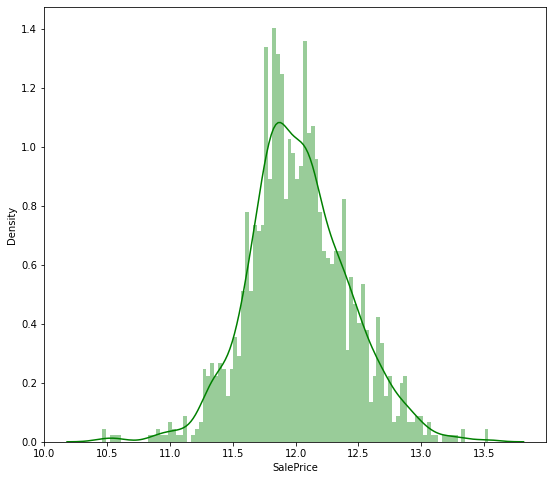

In [8]:
# Normal distribution is better for machine learning
plt.figure(figsize=(9, 8))
sns.distplot(np.log(train['SalePrice']), color='g', bins=100, hist_kws={'alpha': 0.4})

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>],
       [<AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>]], dtype=object)

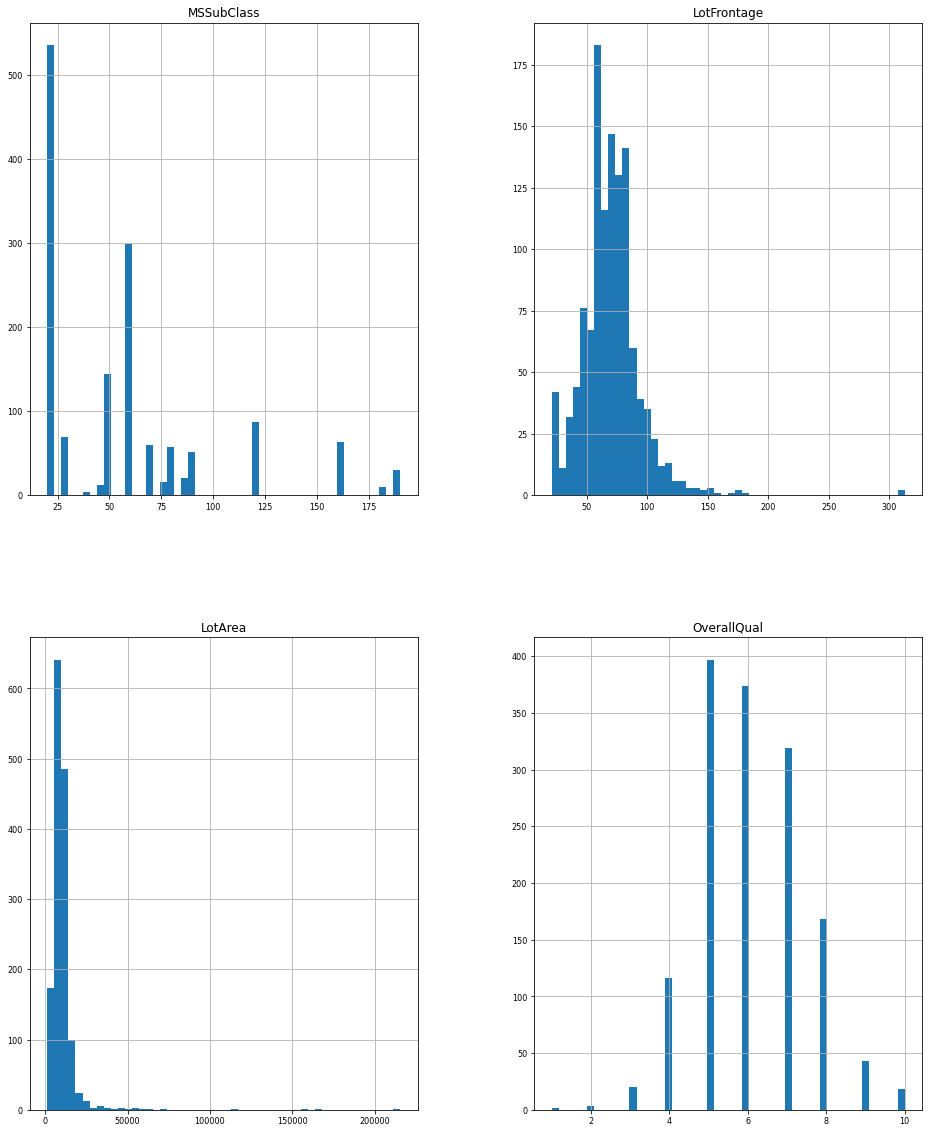

In [16]:
# look at the continuous data
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num = df_num[df_num.columns.to_list()[1:5]]
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

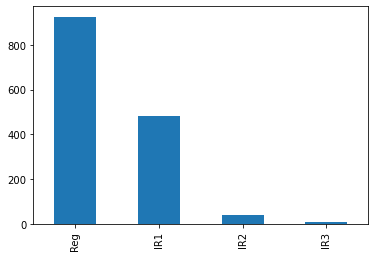

In [40]:
# look at the categorical data
df_cat = train.select_dtypes(include = ['object'])
df_cat = df_num[df_num.columns.to_list()[1:5]]
df_cat['LotShape'].value_counts().plot(kind='bar')

<AxesSubplot:>

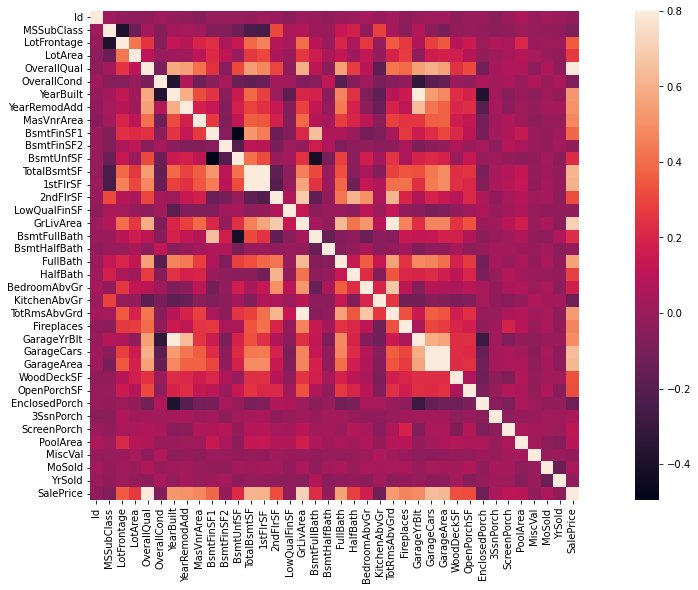

In [9]:
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

## Multi-variables analysis